# Exploring singlepoint

In [65]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
import seaborn as sns
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import py3Dmol


# For highlight colors
from matplotlib.colors import ColorConverter
from matplotlib.ticker import MultipleLocator

from ipywidgets import interact,fixed,IntSlider


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Utility functions from nitrogenase module
sys.path.insert(0, '/home/magstr/Documents/nitrogenase/niflheim_scripts/nitrogenase/backup_plot_diagram')
from data_handler import renamed_load, extract_scoring3,extract_scoring2, extract_scoring1
    
# Custom functions 
from my_utils.visualization import draw_generation,conf_viewer, natural_keys, atoi
from my_utils.classes import Generation, Conformers

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


plt.style.use("science")


dft_base = Path('/home/magstr/dft_data')

HARTREE2EV = 27.2114
HARTREE2KCAL = 627.51
kcal = 627.51
ev = 27.2114

In [2]:
extract_scoring1

<function data_handler.extract_scoring1(logfile)>

In [3]:
# Scoring function dict
funcs = {
        "rdkit_embed_scoring": extract_scoring1,
        "rdkit_embed_scoring_NH3toN2": extract_scoring2,
        "rdkit_embed_scoring_NH3plustoNH3": extract_scoring3,
    }

## Load the reference energies

In [4]:
(
        reactions_gfn1_corrected,
        reactions_gfn2_corrected,
        reactions_dft_ams_tzp,
        reactions_dft_orca_tzp,
        reactions_dft_orca_svp_tzp,
        reactions_dft_orca_sarcJ_tzp
    ) = read_parts()

NameError: name 'read_parts' is not defined

In [ ]:
reactions_dft_orca_sarcJ_tzp

In [ ]:
reactions_dft_orca_tzp

In [ ]:
reference_dft_scoring_values = {'NH3_toN2': 18.849,'NH3+toNH3': 8.761195885483176,'NH3toNH3_N2': 10.715871259570122}

NH3->N2 : -11.0351

NH3->N2_NH3 : -13.5287

NH3+->NH3 : 18.2909

In [ ]:
# Tmp 
NH3 = -5540.467580229754
N2 = -5593.495682161738

print(f'Scoring:= {N2*kcal + reactions_dft_orca_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_tzp["N2"])}')

In [ ]:
# Here i hardtested the discrepancy in the two basis sets. 

N2=-5361.363
NH3=-5308.333
print(f'Without def2/j: Delta = {N2*kcal + reactions_dft_orca_sarcJ_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_sarcJ_tzp["N2"])}')
      
N2=-5525.381
NH3=-5472.404
print(f'With def2/j: Delta = {N2*kcal + reactions_dft_orca_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_tzp["N2"])}')
      

# Singlepoint from GA analysis (before ind was saved)

# Singlepoint from GA analysis multiple

In [ ]:
# Reference paths: 
# For comparing the dej2 and nodef2 results
# Path('/home/magstr/dft_data/prod_new12_0_def2j'),Path('/home/magstr/dft_data/prod_new12_0')

In [ ]:
logfiles = [dft_base/'prod_new22_large_0_long_def2j']
#logfiles = [dft_base / 'prod_new26_2score_large_0',dft_base / 'prod_new26_2score_large_0']

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))

file = logfiles[0]

f1 = sorted(logfiles[0].glob('*[!.csv]'))

# Get the scoring funtion that was used
if sorted(file.glob('*/Mo_NH3+')):
    scoring = 'rdkit_embed_scoring_NH3plustoNH3'
elif sorted(file.glob('*/Mo_N2_NH3')):
    scoring = 'rdkit_embed_scoring'
    print('setting rkdit_embed_scoring')
elif sorted(file.glob('*/Mo_N2')):
    scoring = 'rdkit_embed_scoring_NH3toN2'

print(f'Scoring used: {scoring}')
inds,deltas = funcs[scoring](f1)
print(f'deltas for f1:{deltas}')


gen = Generation(molecules=inds)
df = gen.gen2pd()
df['DFT'] = deltas
df['score'] = df['score'].apply(lambda x: round(x, 1))
df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
df.sort_values(by=['score'], inplace=True)

# Save DF
#df.to_csv(dataframe_path)
# Scoring function dict
df[['score','DFT',]].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *',xlabel='')
ax.legend(['score','DFT'])
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()

#fig.savefig('img.png',dpi=600)

In [ ]:
# 200 HARTREE DIFFERENCE"!!!!!

In [ ]:
N2 = -6218.396054880547
NH3 = -6165.431811449106

In [ ]:
# Test debug auxilliary basis 26,15
delta = (N2 * kcal + reactions_dft_orca_sarcJ_tzp["NH3"]) - (
                        NH3 * kcal + reactions_dft_orca_sarcJ_tzp["N2"]
                    )

In [ ]:
delta

In [ ]:
NH3 = -6001.356992364919
N2 = -6054.384083461080

### Standard comparing all in same plot

In [5]:
logfiles = [dft_base / 'prod_new22_large_0',dft_base/'prod_new22_large_0_long_def2j']
#logfiles = [dft_base / 'prod_new26_2score_large_0',dft_base / 'prod_new26_2score_large_0']

deltas for f1:[-24.81226750742644, -23.932158107403666, -28.80277380067855, -22.804702115710825, -28.145268737804145, -28.343148314394057, -32.78399384114891, -30.358425537124276, 10.662709436845034, -29.18939368892461]


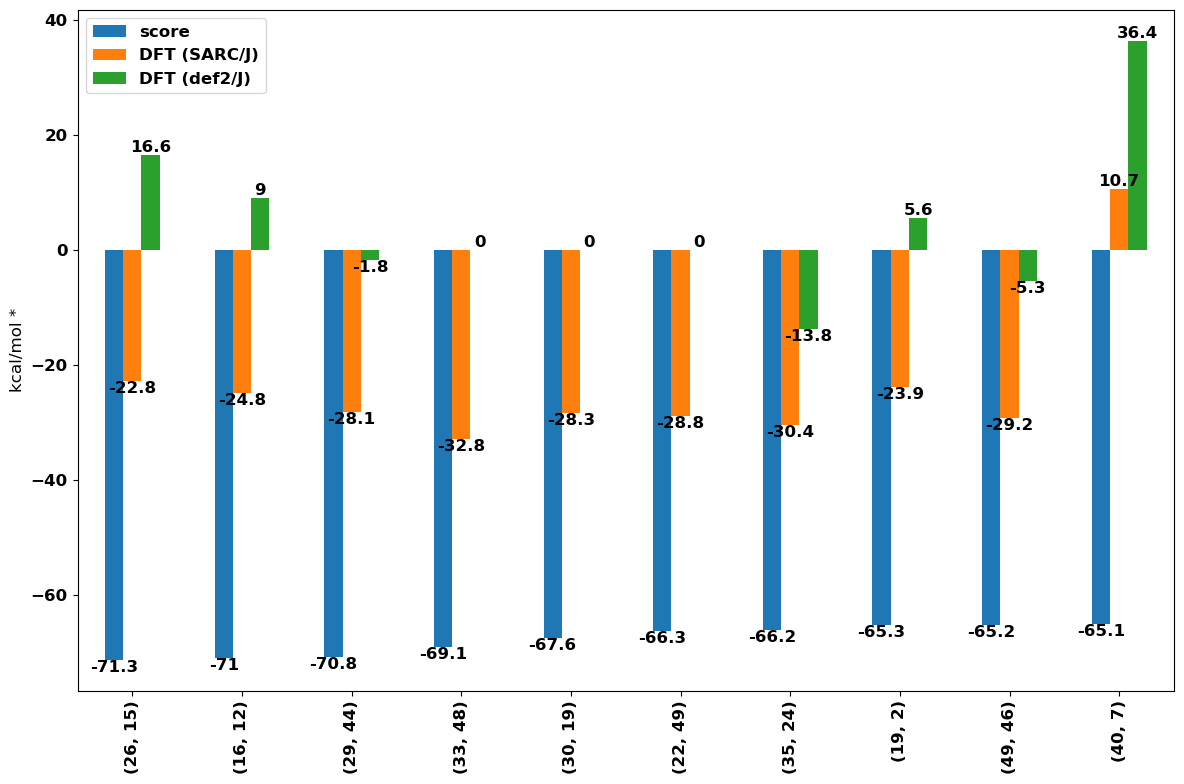

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

file = logfiles[0]

f1 = sorted(logfiles[0].glob('*[!.csv]'))
f2 = sorted(logfiles[1].glob('*[!.csv]'))


tmp = []
for elem in f2:
    if any(elem.name in str(x) for x in f1):
        tmp.append(elem)

f2 = tmp
del f2[-4]


# Get the scoring funtion that was used
if sorted(file.glob('*/Mo_NH3+')):
    scoring = 'rdkit_embed_scoring_NH3plustoNH3'
elif sorted(file.glob('*/Mo_N2_NH3')):
    scoring = 'rdkit_embed_scoring'
    print('setting rkdit_embed_scoring')
elif sorted(file.glob('*/Mo_N2')):
    scoring = 'rdkit_embed_scoring_NH3toN2'


inds,deltas = funcs[scoring](f1)
inds2,deltas2 = funcs[scoring](f2)
print(f'deltas for f1:{deltas}')

gen = Generation(molecules=inds)
df = gen.gen2pd()
df['DFT'] = deltas
df['DFT2'] = deltas2
df['score'] = df['score'].apply(lambda x: round(x, 1))
df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
df['DFT2'] = df['DFT2'].apply(lambda x: round(x, 1))
df.sort_values(by=['score'], inplace=True)

# Save DF
#df.to_csv(dataframe_path)
# Scoring function dict
df[['score','DFT', 'DFT2']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *',xlabel='')
ax.legend(['score','DFT (SARC/J)', 'DFT (def2/J)'])
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()

fig.savefig('img.png',dpi=600)

### 

### One plot for each

In [7]:
#logfiles = [dft_base/'prod_new24_1score_large_0',dft_base/'prod_new23_1score_large_0',dft_base/'prod_new25_2score_large_0',dft_base/'prod_new12_0',dft_base/'prod_new20_large_0',dft_base/'prod_new19_large_0']

logfiles = [dft_base/'prod_new26_2score_large_0']
num_plots = len(logfiles)

/home/magstr/dft_data/prod_new26_2score_large_0


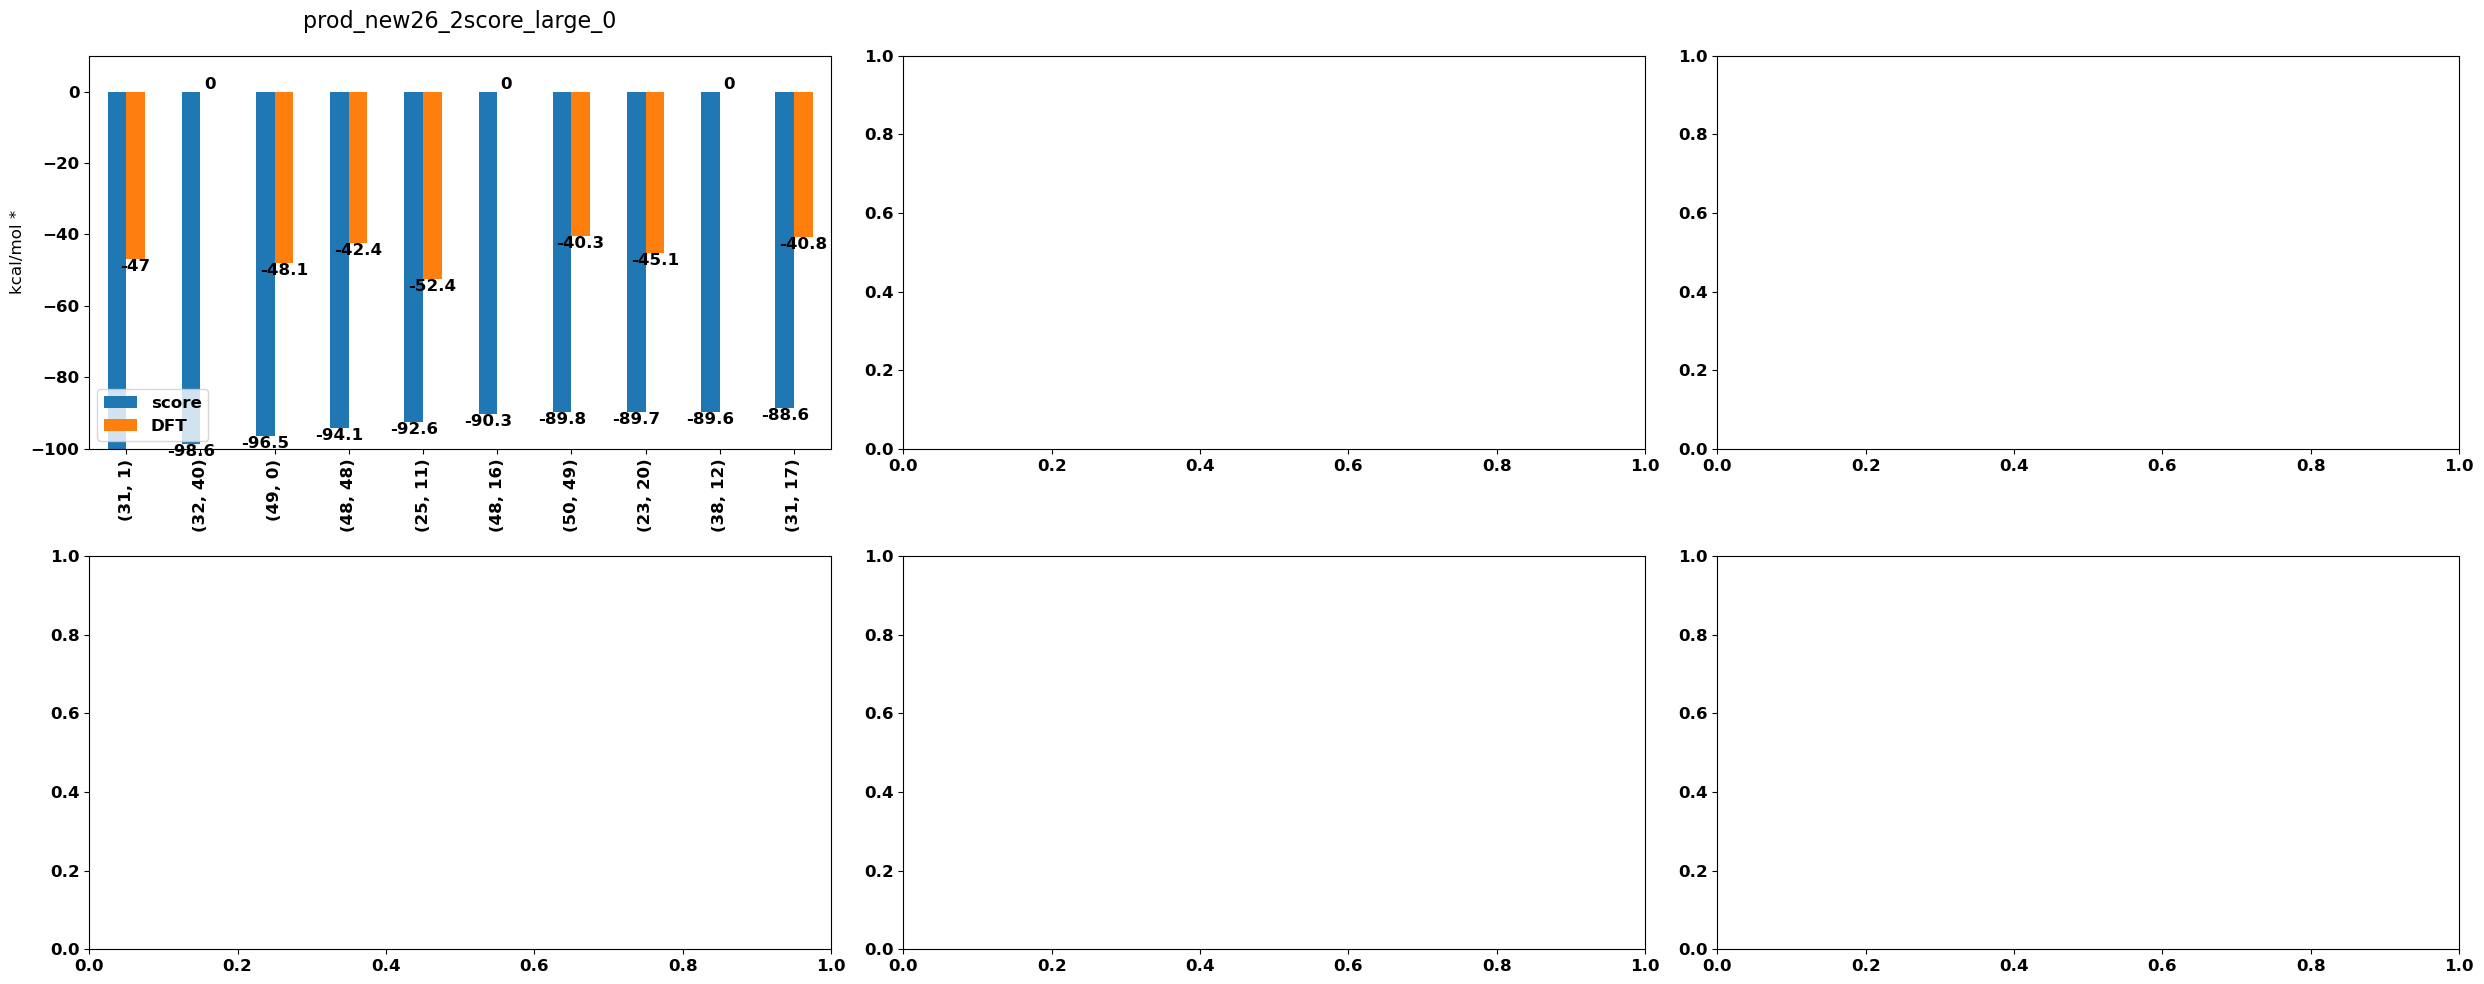

In [8]:
# Init figure
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(25, 10));
ax = ax.flatten()

for i,file in enumerate(logfiles):
    print(file)
    ax_i=ax[i]
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
        print('setting rkdit_embed_scoring')
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
    else:
        print(scoring,f)
        inds,deltas = funcs[scoring](f)
        
        gen = Generation(molecules=inds)
        df = gen.gen2pd()
        df['DFT'] = deltas
        df['score'] = df['score'].apply(lambda x: round(x, 1))
        df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
        df.sort_values(by=['score'], inplace=True)
        
        # Save DF
        df.to_csv(dataframe_path)
        
    df[['score','DFT']].plot.bar(ax=ax_i);
    ax_i.set(ylabel='kcal/mol *',ylim=(-100,10), xlabel='')
    ax_i.set_title(f[0].parent.name,fontsize = 16, pad=20)
    #ax.set_xticks([f'Molecule {x}' for x in range(5)])
    for container in ax_i.containers:
        ax_i.bar_label(container)
fig.tight_layout()

## Bar and correlation plots

In [9]:
logfiles = [dft_base/'prod_new15_large_0', dft_base/'prod_new16_large_0', dft_base/'prod_new17_large_0', dft_base/'prod_new18_large_0', dft_base/'prod_new19_large_0',\
            dft_base/'prod_new21_large_0', dft_base/'prod_new22_large_0', dft_base/'prod_new23_1score_large_0', dft_base/'prod_new24_1score_large_0',\
            dft_base/'prod_new26_2score_large_0', dft_base/'prod_new27_small_0', dft_base/'prod_new28_small_0',dft_base/'prod_new29_small_0',\
            dft_base/'prod_new30_small_0', dft_base/'prod_new31_small_charge_0', dft_base/'prod_new32_small_0', dft_base/'prod_new33_charge_small_0',dft_base/'prod_new34_charge_small_0',dft_base/'prod_new35_charge_small_0',\
           dft_base/'prod_new36_charge_small_0', dft_base/'prod_new39_charge_small_0', dft_base/'prod_new39_charge_small_0_1', dft_base/'prod_new39_charge_small_0_1_2']
num_plots = len(logfiles)

In [10]:
len(logfiles)

23

In [11]:
# Something is wrong with 20 and 25

In [12]:
# Test something

/home/magstr/dft_data/prod_new15_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new16_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new17_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new18_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new19_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new21_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new22_large_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new23_1score_large_0
rdkit_embed_scoring
/home/magstr/dft_data/prod_new24_1score_large_0
rdkit_embed_scoring
/home/magstr/dft_data/prod_new26_2score_large_0
rdkit_embed_scoring_NH3plustoNH3
/home/magstr/dft_data/prod_new27_small_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new28_small_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new29_small_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/prod_new30_small_0
rdkit_embed_scoring_NH3toN2
/home/magstr/dft_data/pr

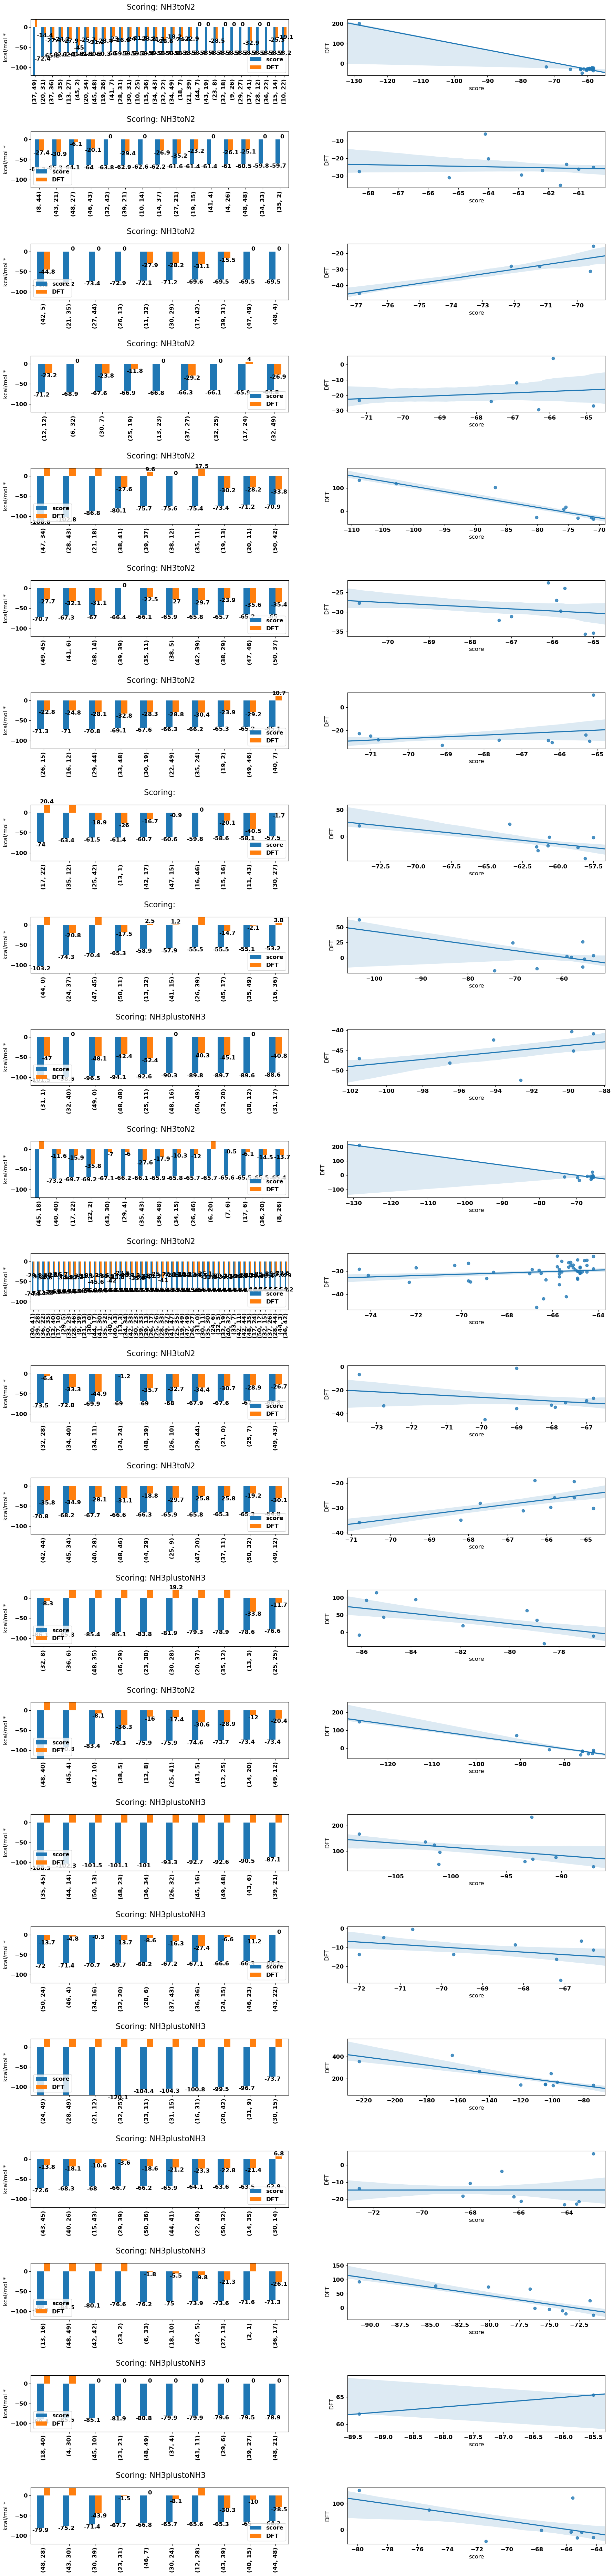

In [16]:
top_list = []


# Init figure
fig, ax = plt.subplots(nrows=num_plots,ncols=2,figsize=(18, 75));

for i,file in enumerate(logfiles):
    print(file)
    
    ax_i = ax[i,0]
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'
    print(scoring)

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
        
    else:
        inds,deltas = funcs[scoring](f)
        
        gen = Generation(molecules=inds)
        df = gen.gen2pd()
        df['DFT'] = deltas
        df['score'] = df['score'].apply(lambda x: round(x, 1))
        df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
        df.sort_values(by=['score'], inplace=True)
        df['scoring'] = [scoring]*len(inds)
        
        # Save DF
        df.to_csv(dataframe_path)
        
        # Append good scoring molecules to list
        arr =np.array(deltas)
        # Reference DFT energy for original catalyst for the N2 to 
        arr = arr<20
        lst = [ind for ind,condition in zip(inds,arr) if condition]
        top_list.extend(lst)
        
    df[['score','DFT']].plot.bar(ax=ax_i);
    ax_i.set(ylabel='kcal/mol *',ylim=(-120,20), xlabel='')
    
    # Folder title: f[0].parent.name
    ax_i.set_title(f' Scoring: {scoring[20:]}',fontsize = 16, pad=20)
    #ax.set_xticks([f'Molecule {x}' for x in range(5)])
    for container in ax_i.containers:
        ax_i.bar_label(container)
        
        
    # Plot corresponding correlation pplot
    sns.regplot(x="score", y="DFT",ci=68,truncate=False,data=df[df['DFT']!=0], ax=ax[i,1]);
        
    
# Magic
fig.tight_layout(h_pad=2, w_pad=5)

#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

## Get the best scoring molecules over different generations and visualize them 

In [18]:
total_df = pd.DataFrame(columns=['score', 'energy', 'sa_score', 'rdkit_mol', 'DFT', 'smiles'])
for i,file in enumerate(logfiles):
    print(file)
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    
    dataframe_path = f[0].parent /'df.csv'
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
        total_df=pd.concat([total_df,df])

/home/magstr/dft_data/prod_new15_large_0
/home/magstr/dft_data/prod_new16_large_0
/home/magstr/dft_data/prod_new17_large_0
/home/magstr/dft_data/prod_new18_large_0
/home/magstr/dft_data/prod_new19_large_0
/home/magstr/dft_data/prod_new21_large_0
/home/magstr/dft_data/prod_new22_large_0
/home/magstr/dft_data/prod_new23_1score_large_0
/home/magstr/dft_data/prod_new24_1score_large_0
/home/magstr/dft_data/prod_new26_2score_large_0
/home/magstr/dft_data/prod_new27_small_0
/home/magstr/dft_data/prod_new28_small_0
/home/magstr/dft_data/prod_new29_small_0
/home/magstr/dft_data/prod_new30_small_0
/home/magstr/dft_data/prod_new31_small_charge_0
/home/magstr/dft_data/prod_new32_small_0
/home/magstr/dft_data/prod_new33_charge_small_0
/home/magstr/dft_data/prod_new34_charge_small_0
/home/magstr/dft_data/prod_new35_charge_small_0
/home/magstr/dft_data/prod_new36_charge_small_0
/home/magstr/dft_data/prod_new39_charge_small_0
/home/magstr/dft_data/prod_new39_charge_small_0_1
/home/magstr/dft_data/prod

In [22]:
total_df

,score,energy,sa_score,rdkit_mol,DFT,smiles,cut_idx,scoring
"(37, 49)",-128.5,-129.750386,0.990219,NaN,201.0,NCC(N)c1ccc(CCl)cc1,0.0,rdkit_embed_scoring_NH3toN2
"(20, 31)",-72.4,-72.413743,1.000000,NaN,-14.4,CNCC(N)c1ccc(CCl)cc1,10.0,rdkit_embed_scoring_NH3toN2
"(37, 36)",-65.2,-65.238807,1.000000,NaN,-27.3,CC(N)CCC1CCC1,8.0,rdkit_embed_scoring_NH3toN2
"(9, 35)",-62.1,-62.113881,1.000000,NaN,-24.2,CNCC(N)c1ccc(F)cc1Cl,5.0,rdkit_embed_scoring_NH3toN2
"(13, 27)",-62.1,-62.081733,1.000000,NaN,-27.9,CCCCCCN,6.0,rdkit_embed_scoring_NH3toN2
...,...,...,...,...,...,...,...,...
"(30, 24)",-65.7,-65.655672,1.000000,NaN,-8.1,Nc1ccc(F)c(F)c1C(=O)F,11.0,rdkit_embed_scoring_NH3plustoNH3
"(12, 28)",-65.6,-69.033737,0.950404,NaN,122.2,NC(NS)c1cccc(F)c1,4.0,rdkit_embed_scoring_NH3plustoNH3
"(43, 39)",-65.3,-67.544985,0.966409,NaN,-30.3,Nc1ccc(F)cc1C(=O)C(F)=S,10.0,rdkit_embed_scoring_NH3plustoNH3
"(40, 15)",-65.0,-66.171834,0.982412,NaN,-10.0,NC(CC=S)c1cccc(F)c1,5.0,rdkit_embed_scoring_NH3plustoNH3


In [86]:
len(np.arange(min(total_df['DFT']), max(total_df['DFT']) + 10, 10))

48

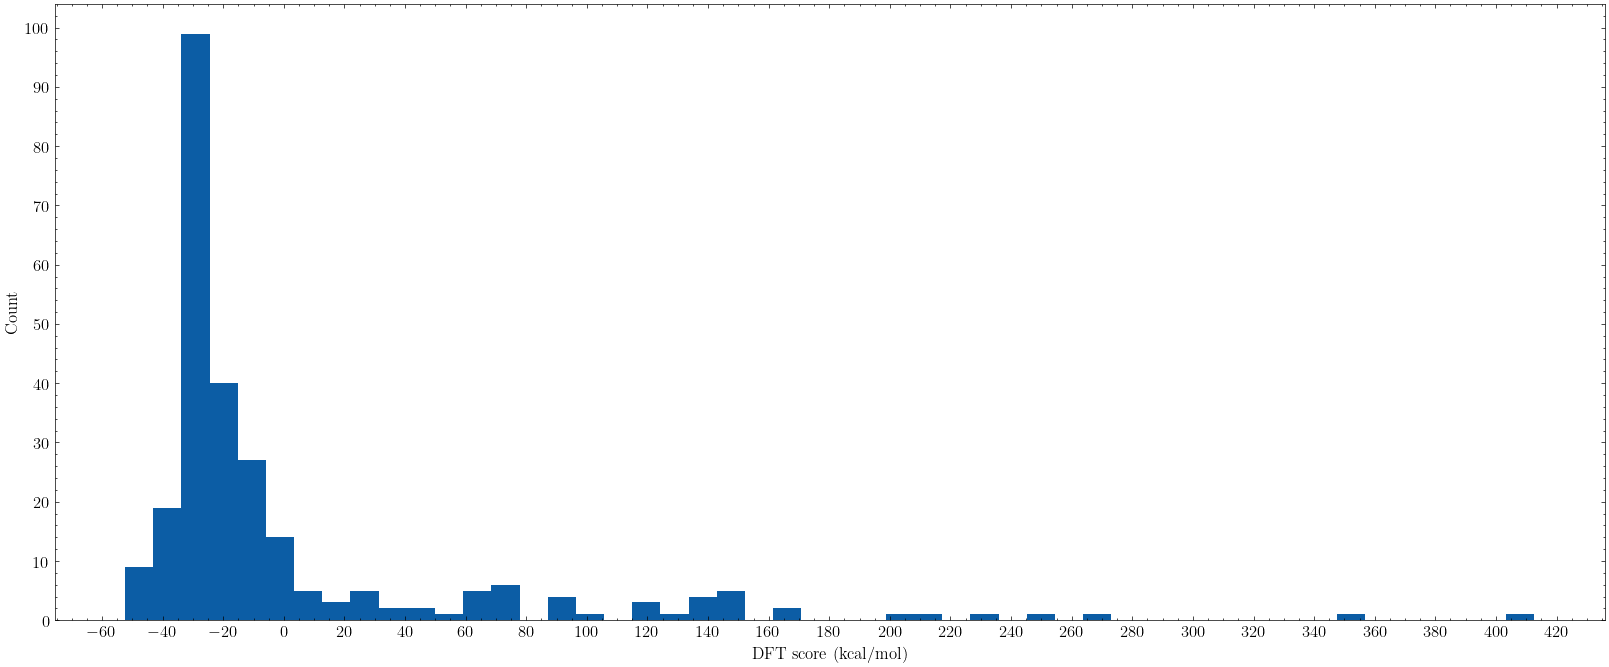

In [87]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.hist(total_df['DFT'], bins=50)
ax.set(xlabel='DFT score (kcal/mol)', ylabel='Count')
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(20))

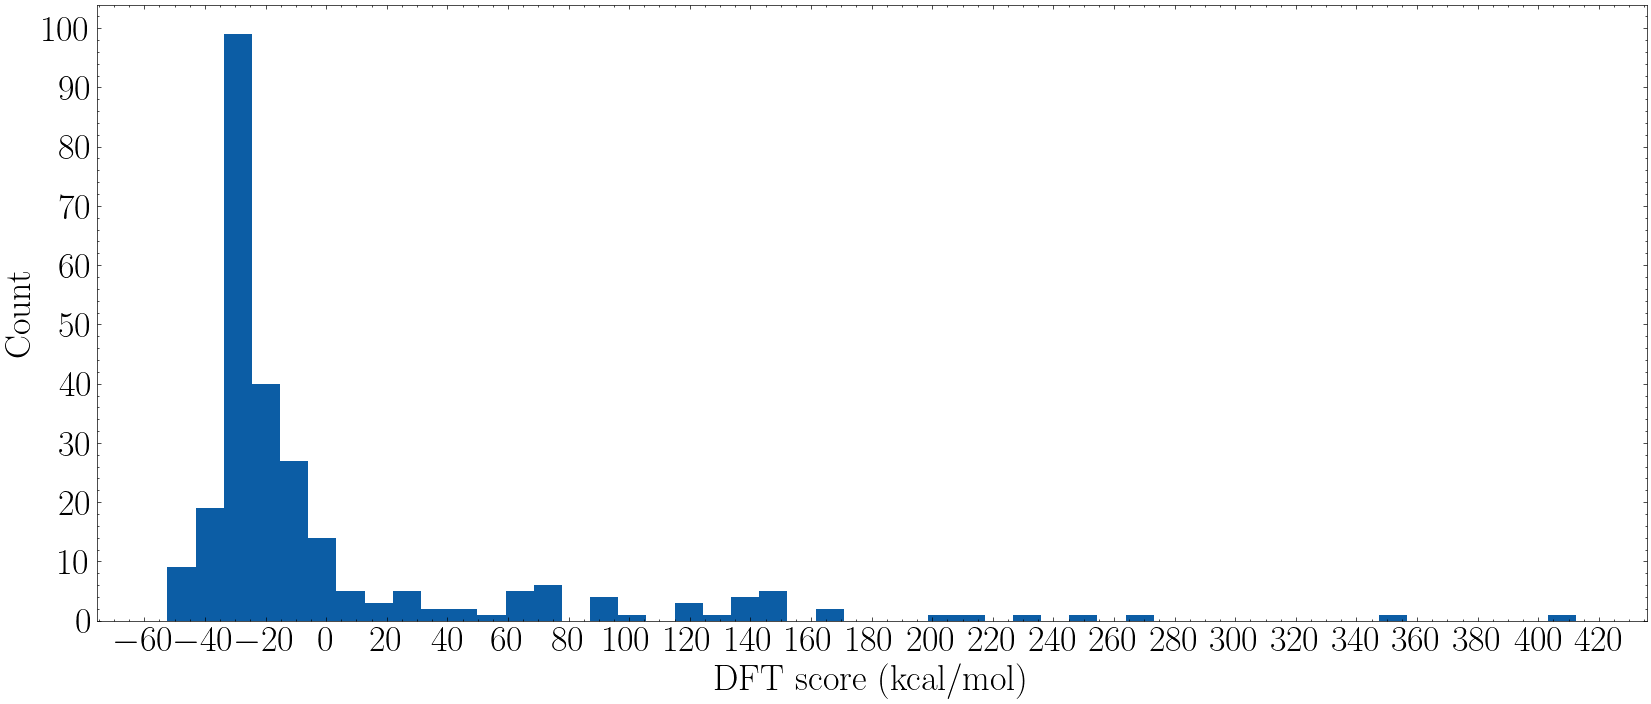

In [91]:
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(26)
fig.savefig('/home/magstr/Documents/Paper/figures/dft_distribution.pdf')
fig

In [ ]:
mols = [Chem.MolFromSmiles(x) for x in total_df['smiles']]
score = [round(score,2) for score in total_df['score']]
score_xtb = [round(score,2) for score in total_df['energy']]
scoring_functions = [func for func in total_df['scoring']]

In [ ]:
f_maps = {'rdkit_embed_scoring': 'NH3 -> NH3 - N2',
         'rdkit_embed_scoring_NH3toN2': 'NH3 -> N2', 
         'rdkit_embed_scoring_NH3plustoNH3':'NH3+ -> NH3'}

In [ ]:
img  = Draw.MolsToGridImage(mols,molsPerRow=4,maxMols=300,legends=[f'{f_maps[scoring_function]}  |  Score:  {score}' for scoring_function, score,score_xtb in zip(scoring_functions,score,score_xtb)],subImgSize=(400,200), returnPNG=False)
img.save('299GA.png', format='png')
img

In [ ]:
extract = total_df[total_df['DFT']<20]

In [ ]:
final = extract[extract.apply(lambda x: CalcNumRotatableBonds(Chem.MolFromSmiles(x['smiles'])) <= 4, axis=1)]

In [8]:
len(final)

0

In [9]:
mols = [Chem.MolFromSmiles(x) for x in final['smiles']]
idx = range(0,len(final))
score = [score for score in final['scoring']]
idx_gen = [idx_gen for idx_gen in final.index]

KeyError: 'scoring'

In [10]:
img  = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=100,legends=[f'{x}    {score} idx: {idx}' for x, score, idx in zip(idx,score, idx_gen)],subImgSize=(400,200), useSVG=True)
img

NameError: name 'score' is not defined

In [11]:
with open('mol.svg','w') as f:
    f.write(img.data)

NameError: name 'img' is not defined

In [12]:
#img.save('candidates', format='png')

In [13]:
# NH3 -> N2
#0, 65

# NH3 -> N2_NH3
#42, 43

# NH3plus to NH3
#47, 49
    

In [14]:
final = final.iloc[[99,98,97,89,40,52,41,21]]

IndexError: positional indexers are out-of-bounds

In [15]:
final['rdkit_mol'].values.tolist()

[]

In [16]:
final.to_csv('second_conformers.csv')